# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
The objective of this project is to identify lane lines on the road, starting with a pipeline on a series of individual images, and later apply the result to a video stream.

This project has used the following tools:
* Grayscaling
* Canny Edge Detection
* Gaussian smoothing
* Region of interest selection
* Color selection
* Hough Tranform line detection

---
Outcome example: For image --'test_images/solidWhiteRight.jpg'. 
---

---

<figure>
 <img src="./examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> The output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="./examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> The goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [1]:
import os
import math

import numpy as np
from scipy import interpolate
import cv2

# For plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Libraries to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Sample Image Visulization

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


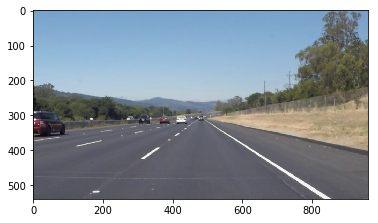

In [2]:
# reading in an image in RGB channels
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  

## Helper Functions

In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel for smoothing"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """Applies an image mask
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # Defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # Defining a 3 channel or 1 channel color to fill the mask 
    # with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """Draw lines with specific color and thickness
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Additional Helper Functions for Hough Lines

In [4]:
def separate_lines(lines):
    """ 
    separate lines by +/- slope.
    +: right lane
    -: left lane
    """
    right = []
    left = []
    for x1, y1, x2, y2 in lines[:, 0]:
        m = (float(y2) - y1) / (x2 - x1)
        if m >= 0: 
            right.append([x1, y1, x2, y2, m])
        else:
            left.append([x1, y1, x2, y2, m])
    
    return right, left

def reject_outliers(lines,  m1=0.4, m2=0.5):
    """
    Remove the lines for slope out of m1 to m2
    """
    new_lines = []
    for x1, y1, x2, y2, m in lines:
        if (m >= m1 and m <= m2):
            new_lines.append([x1, y1, x2, y2])
    return new_lines

def extra_and_combine(lines):
    """
    Extrapolate and combine lines into a single line
    """
    # Extrapolate the lines
    x=lines[0, 0, 0:3:2]
    y=lines[0, 0, 1:4:2]
    starts_ends_y = np.array([[[540, 315]]])
    f = interpolate.interp1d(y, x, fill_value='extrapolate')
    starts_ends_x =np.array([[[f(starts_ends_y[0, 0, 0]), f(starts_ends_y[0, 0, 1])]]])
    
    # Define the single line
    x1=starts_ends_x[0, 0, 0]
    y1=starts_ends_y[0, 0, 0]
    x2=starts_ends_x[0, 0, 1]
    y2=starts_ends_y[0, 0, 1]
    long_lines =np.array([[[x1, y1, x2, y2]]], dtype='int16')
    
    return long_lines

def merge_lines(lines):
    """
    Average and extrapolate lines
    """
    linesa = np.asarray(lines)
    if linesa.size != 0:
        linesb = linesa.reshape(linesa.shape[0], 1, linesa.shape[1])
        # Average the lines coordinates
        merged_lines = np.mean(linesb, 0)
    
        result_lines = merged_lines.reshape(merged_lines.shape[0], 1, merged_lines.shape[1])
        result_lines = result_lines.astype('int')
    
        # Return extrapolated lines
        return extra_and_combine(result_lines)

## Build a Lane Finding Pipeline



Build the pipeline and run the solution on all test_images.

In [5]:
def pipeline(image):
    # Gray scale conversion
    gray = grayscale(image)
    
    # Gaussian smoothing / blurring
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)

    # Find canny edges
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Params for region of interest
    imshape = image.shape
    bot_left = [80, imshape[0]] # imshape[0]=540
    bot_right = [900, imshape[0]]
    apex_right = [510, 315]
    apex_left = [450, 315]
    vertices = [np.array([bot_left, bot_right, apex_right, apex_left], dtype=np.int32)]
    
    # Create masked edges
    masked_edges = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    rho = 1            # distance resolution in pixels of the Hough grid
    theta = np.pi/180  # angular resolution in radians of the Hough grid
    threshold = 30     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 100 # minimum number of pixels making up a line
    max_line_gap = 160 # maximum gap in pixels between connectable line segments

    # Run Hough Lines on edge detected image and separate by +/- slope
    # And then average and extrapolate the lines, which was done by merge_lines()
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)

    right_lines, left_lines = separate_lines(lines)
    right = reject_outliers(right_lines,  0.45, 0.75)
    right = merge_lines(right)
    
    left = reject_outliers(left_lines, -0.85, -0.6)
    left = merge_lines(left)

    lines = np.concatenate((right, left))
    
    # Make a blank the same size as our image to draw on
    line_image = np.copy(image)*0
    
    # Draw lines and return combo image 
    draw_lines(line_image, lines, thickness=10)
    
    line_image = region_of_interest(line_image, vertices)
    combo = weighted_img(line_image, image, α=0.8, β=1., λ=0.)
    
    return combo

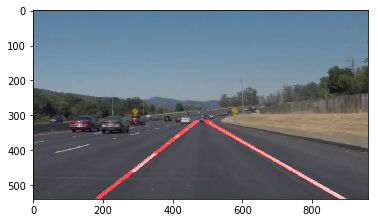

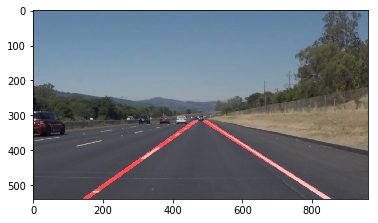

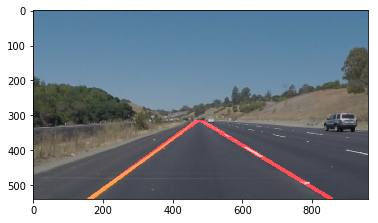

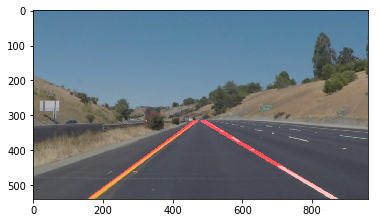

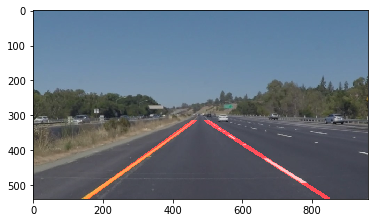

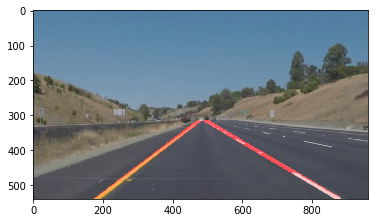

In [6]:
# Run pipeline for images in test_images
test_images = os.listdir("test_images/")
for img in test_images:
    if img != '.DS_Store':
        image = mpimg.imread(os.path.join("test_images", img))
        combo = pipeline(image)
        
        plt.figure()
        plt.imshow(combo)

## Test on Videos

#### Video with white line on the right

In [16]:
white_output = "./examples/white.mp4"
clip1 = VideoFileClip("./examples/solidWhiteRight.mp4")
white_clip = clip1.fl_image(pipeline) # NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./examples/white.mp4
[MoviePy] Writing video ./examples/white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 33.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./examples/white.mp4 

CPU times: user 3.08 s, sys: 678 ms, total: 3.76 s
Wall time: 7.3 s


### Play the video inline

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

#### Video with the solid yellow lane on the left. 

In [18]:
yellow_output = "./examples/yellow.mp4"
clip2 = VideoFileClip('./examples/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video ./examples/yellow.mp4
[MoviePy] Writing video ./examples/yellow.mp4


100%|█████████▉| 681/682 [00:19<00:00, 35.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./examples/yellow.mp4 

CPU times: user 9.59 s, sys: 2.07 s, total: 11.7 s
Wall time: 20.5 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))